<a href="https://www.kaggle.com/code/eslamsharoud/animal-faces-with-pytorch?scriptVersionId=264119706" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.optim import Adam # Adam Optimizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers

from PIL import Image # Used to read the images from the directory

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)
     

Device available:  cuda


# Load and display data

In [2]:
data_dir= "/kaggle/input/animal-faces/afhq"
folders = os.listdir(data_dir)
image_paths = []
labels = []

for split in ["train", "val"]:
    split_path = os.path.join(data_dir, split)

    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_paths.append(image_path)
            labels.append(class_name)

df=pd.DataFrame({'image_path': image_paths, 'label': labels})

df.head()

,image_path,label
0,/kaggle/input/animal-faces/afhq/train/dog/pixa...,dog
1,/kaggle/input/animal-faces/afhq/train/dog/pixa...,dog
2,/kaggle/input/animal-faces/afhq/train/dog/flic...,dog
3,/kaggle/input/animal-faces/afhq/train/dog/flic...,dog
4,/kaggle/input/animal-faces/afhq/train/dog/flic...,dog


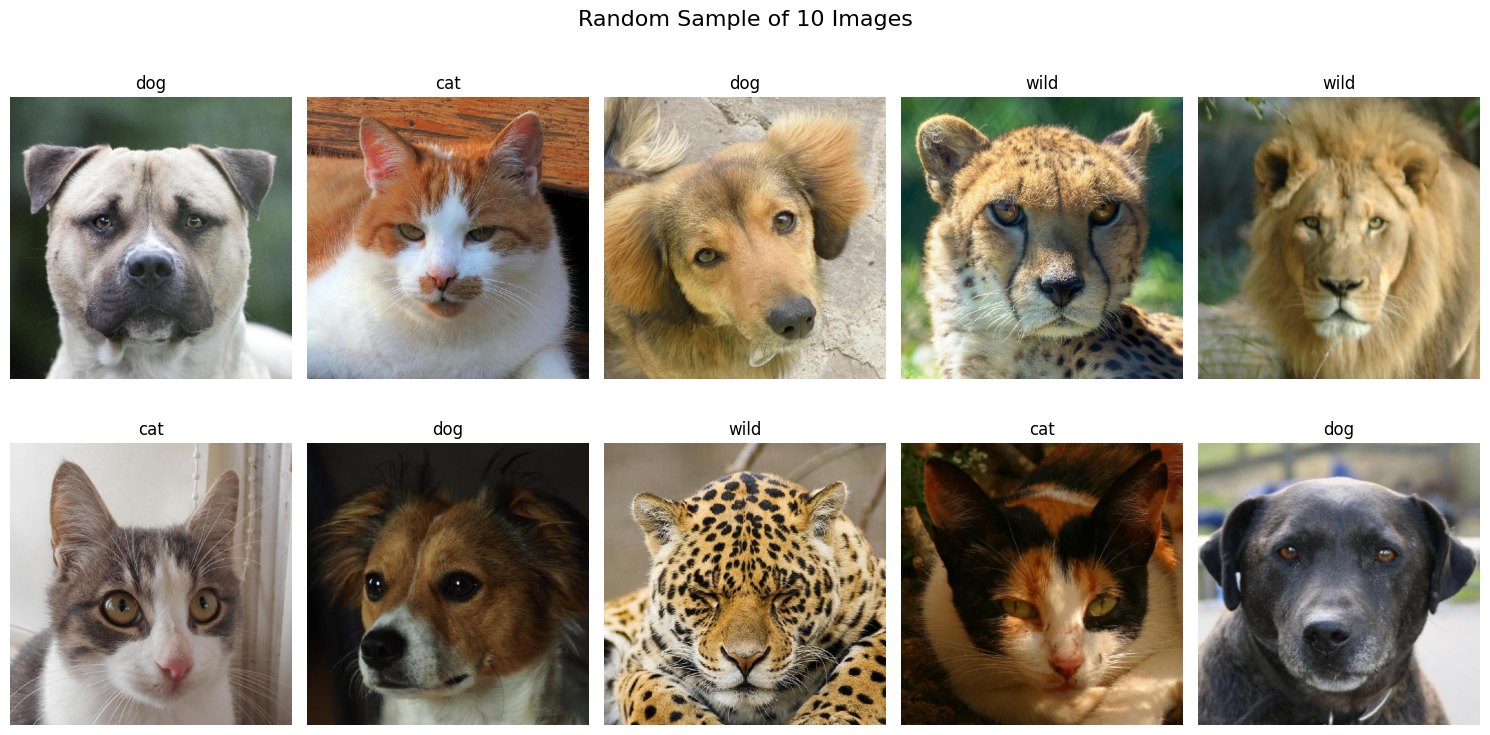

In [3]:
import cv2

sample_data=df.sample(10) # ----> show random 10 images from dataset

plt.figure(figsize=(15, 8))

for idx, img_path in enumerate(sample_data['image_path']):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, idx+1)  
    plt.imshow(img)
    plt.title(sample_data['label'].iloc[idx])
    plt.axis('off')
plt.suptitle("Random Sample of 10 Images", fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# plot category of animal

import plotly.express as px

fig = px.histogram(
    df, 
    x="label", 
    color="label",          # differnt color in each column
    text_auto=True,         # write number for each column
    title="Number of Images per Class"
)

fig.update_layout(
    xaxis_title="Class",
    yaxis_title="Count",
    title_x=0.5,            
    bargap=0.3              
)

fig.show()


# Split Data 


` Training: 70% 
    Validation: 15% 
    Testing: 15%  `

In [5]:
train=df.sample(frac=0.7,random_state=42) # Create training of 70% of the data
test=df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=42) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


# Preprocess 

In [6]:
label_encoder=LabelEncoder()
label_encoder.fit(df['label']) # Fit the label encoder on our own data

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

#  Custom Dataste Class

In [7]:
class CustomDataset(Dataset):
    def __init__(self,dataframe,transform):
        self.dataframe=dataframe
        self.transform=transform
        self.label = torch.tensor(label_encoder.transform(dataframe['label'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self,idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.label[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image) 

        return image, label


In [8]:
train_dataset = CustomDataset(dataframe=train, transform=transform)
val_dataset = CustomDataset(dataframe=val, transform=transform)
test_dataset = CustomDataset(dataframe=test, transform=transform)

# hyper parameter

In [9]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 10

# DataLoader

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,32,kernel_size = 3, padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size = 3,padding=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size = 3,padding=1)

        self.relu = nn.ReLU()
        self.maxpooling = nn.MaxPool2d(2,2)

        self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
        self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
        self.output = nn.Linear(128, len(df['label'].unique())) # Output Linear Layer

    def forward(self, x):
        x = self.conv1(x) # -> Outputs: (32, 128, 128)
        x = self.relu(x)
        x = self.maxpooling(x)# -> Outputs: (32, 64, 64)

        x = self.conv2(x) # -> Outputs: (64, 64, 64)
        x = self.relu(x)
        x = self.maxpooling(x) # -> Outputs: (64, 32, 32)

        x = self.conv3(x) # -> Outputs: (128, 32, 32)
        x = self.relu(x)
        x = self.maxpooling(x) # -> Outputs: (128, 16, 16)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        return x

model = CNN().to(device) # Create an instance of the model and move it to the GPU Device


# Model Summary


In [12]:
from torchsummary import summary
summary(model,input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

# Loss & Optimizer

In [13]:
# Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=LR)

# Training

In [14]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)
     

Epoch 1/10, Train Loss: 2.0133 Train Accuracy 75.3255
              Validation Loss: 0.2493 Validation Accuracy: 88.2231
Epoch 2/10, Train Loss: 0.8416 Train Accuracy 91.4091
              Validation Loss: 0.1761 Validation Accuracy: 91.0744
Epoch 3/10, Train Loss: 0.5961 Train Accuracy 93.6587
              Validation Loss: 0.1158 Validation Accuracy: 94.3802
Epoch 4/10, Train Loss: 0.4518 Train Accuracy 95.2529
              Validation Loss: 0.1024 Validation Accuracy: 95.3306
Epoch 5/10, Train Loss: 0.3426 Train Accuracy 96.4485
              Validation Loss: 0.1069 Validation Accuracy: 94.876
Epoch 6/10, Train Loss: 0.273 Train Accuracy 97.2545
              Validation Loss: 0.089 Validation Accuracy: 96.3223
Epoch 7/10, Train Loss: 0.2034 Train Accuracy 97.963
              Validation Loss: 0.0912 Validation Accuracy: 95.6612
Epoch 8/10, Train Loss: 0.1438 Train Accuracy 98.5564
              Validation Loss: 0.0847 Validation Accuracy: 96.281
Epoch 9/10, Train Loss: 0.1263 Train 

# testing 

In [15]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")
     

Accuracy Score is: 96.3208 and Loss is 0.0094


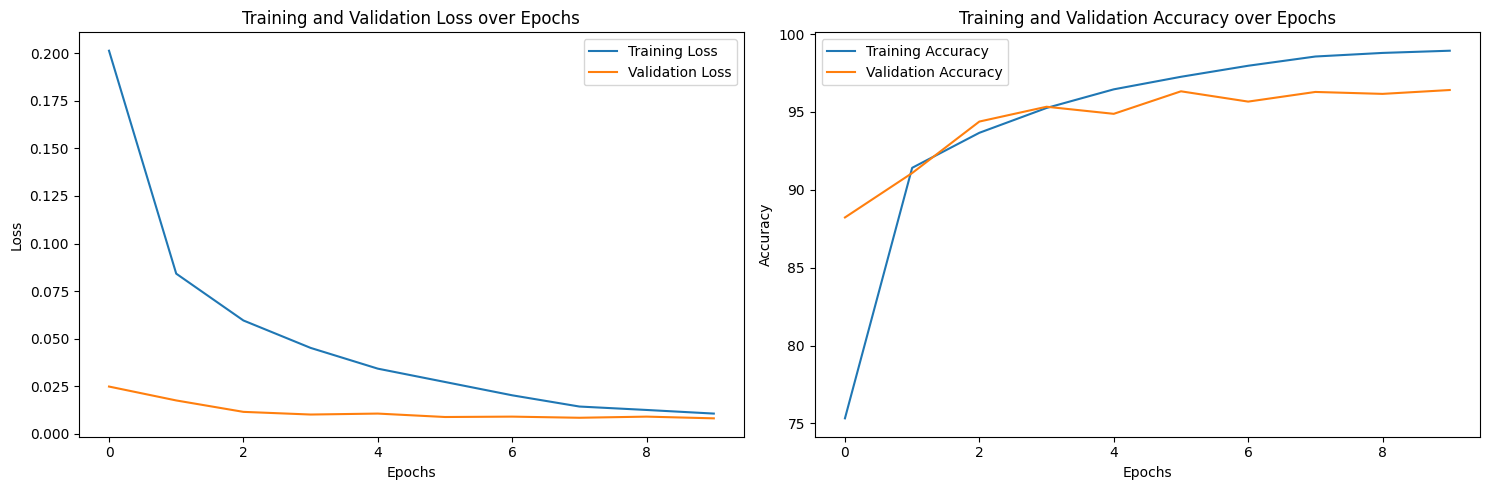

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

# Inference

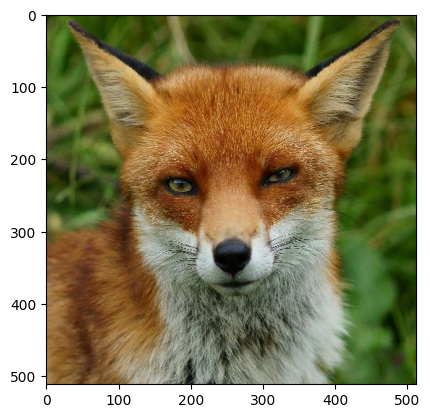


Prediction: 



array(['wild'], dtype=object)

In [17]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000017.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000017.jpg")

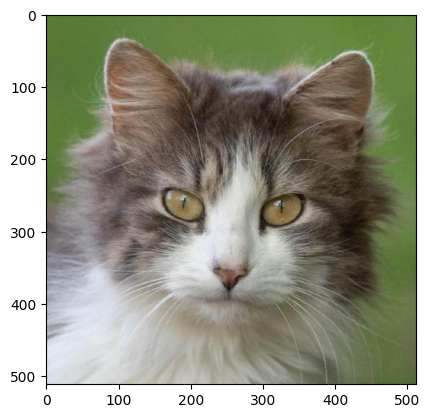


Prediction: 



array(['cat'], dtype=object)

In [18]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/kaggle/input/animal-faces/afhq/val/cat/flickr_cat_000136.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/kaggle/input/animal-faces/afhq/val/cat/flickr_cat_000136.jpg")

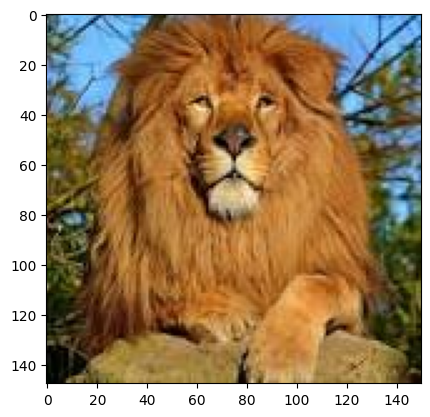


Prediction: 



array(['wild'], dtype=object)

In [19]:

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/kaggle/input/photo-jpg/download.jfif")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/kaggle/input/photo-jpg/download.jfif")